CONVOLUTION REVERB

convolving an input signal with an input impulse response

In [4]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy import signal
from scipy.io import wavfile
import simpleaudio as sa
from matplotlib.pyplot import figure
import math
import utility

In [5]:
# ------- MONO -------

In [6]:
audiofile = "/Users/anniechu/Desktop/CantinaBand3.wav"
fs_in, data_in = wavfile.read(audiofile)

.Wav Contents = [   3    7    0 ...  -12 -427 -227]
.Wav Samples Length = 66150
.Wav Channel(s) = 1
.Wav Length = 3.0s
Sampling Rate= 22050 Hz
bit depth= <class 'numpy.int16'>


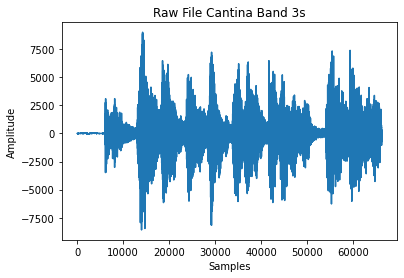

In [7]:
# mono data
print(f".Wav Contents = {data_in}")
print(f".Wav Samples Length = {data_in.shape[0]}")
print(f".Wav Channel(s) = {len(data_in.shape)}")
length = data_in.shape[0] / fs_in
print(f".Wav Length = {length}s")
print(f"Sampling Rate= {fs_in} Hz")
print(f"bit depth= {type(data_in[0])}")

plt.plot(data_in);
plt.title("Raw File Cantina Band 3s");
plt.xlabel("Samples");
plt.ylabel("Amplitude");

In [8]:
#playing mono sound
orig_mono = sa.play_buffer(data_in, 1, 2, fs_in)

In [9]:
orig_mono.stop()

old dtype: int16
new dtype: float32
[ 9.155273e-05  2.136230e-04  0.000000e+00 ... -3.662109e-04 -1.303101e-02
 -6.927490e-03]


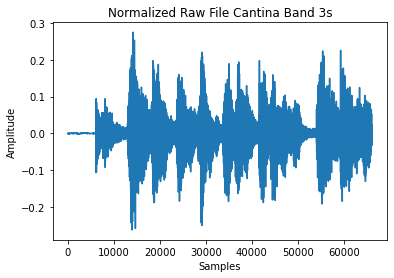

In [10]:
#using utility to convert int16 to float32 as convolving large numbers takes up too long
print("old dtype: {}".format(data_in.dtype))
normalized_din = utility.pcm2float(data_in, 'float32')
print("new dtype: {}".format(normalized_din.dtype))
np.set_printoptions(precision=6)
print(normalized_din)

plt.plot(normalized_din);
plt.title("Normalized Raw File Cantina Band 3s");
plt.xlabel("Samples");
plt.ylabel("Amplitude");

In [11]:
#choose impulse response here!
IR = "/Users/anniechu/Documents/artificialreverb/WireGrind-IR-44100-v2/mono/WireGrind_m_0.8s_06w_900Hz_02m.wav"
fs_IR, data_IR = wavfile.read(IR)

.Wav Contents = [2147483392    -139264    -365824 ...      13568       8704      40448]
.Wav Samples Length = 35280
.Wav Channel(s) = 1
.Wav Length = 1.6s
Sampling Rate= 44100 Hz
bit depth= <class 'numpy.int32'>
sampling rate = 44100 Hz, length = 35280 samples => 1.6 s, channels = 1
[2147483392    -139264    -365824 ...      13568       8704      40448]


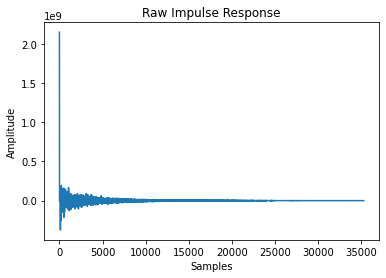

In [12]:
print(f".Wav Contents = {data_IR}")
print(f".Wav Samples Length = {data_IR.shape[0]}")
print(f".Wav Channel(s) = {len(data_IR.shape)}")
len_IR = data_IR.shape[0] / fs_in
print(f".Wav Length = {len_IR}s")
print(f"Sampling Rate= {fs_IR} Hz")
print(f"bit depth= {type(data_IR[0])}")

print(f"sampling rate = {fs_IR} Hz, length = {data_IR.shape[0]} samples => {data_IR.shape[0]/fs_in} s, channels = {len(data_IR.shape)}")
print(data_IR)
plt.plot(data_IR);
plt.title("Raw Impulse Response");
plt.xlabel("Samples");
plt.ylabel("Amplitude");

old dtype: int32
new dtype: float64
[ 9.999999e-01 -6.484985e-05 -1.703501e-04 ...  6.318092e-06  4.053116e-06
  1.883507e-05]


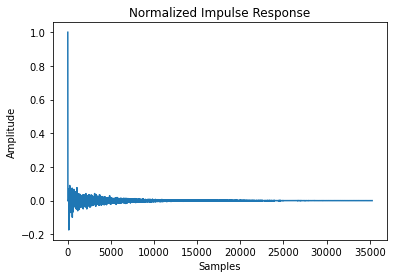

In [13]:
#using utility to convert int32 to float to match the input signal
print("old dtype: {}".format(data_IR.dtype))
normalized_IR = utility.pcm2float(data_IR, "float32")
print("new dtype: {}".format(normalized_IR.dtype))
np.set_printoptions(precision=6)
print(normalized_IR)
plt.plot(normalized_IR);
plt.title("Normalized Impulse Response");
plt.xlabel("Samples");
plt.ylabel("Amplitude");

In [63]:
#matching sampling rates, find upsampling value
print(fs_in)
print(fs_IR)


def match_fs(fs_in, fs_IR, sig, IR):
    upsamp= fs_IR/fs_in; #IR fs divided by fs_in -- if > 1, IR has higher fs; if < 1 data_in has higher fs
    upsamp_data = 0;
    if fs_in > fs_IR: #if samp rate of data is greater than samp rate of IR, take reciprocal
        upsamp = 1/upsamp;
        upsamp_data = IR;
        print("upsample_data: data_IR")

    else:
        upsamp_data = sig;
        print("upsample_data: data_in")

    return int(upsamp), upsamp_data

match_fs(fs_in, fs_IR, data_in, data_IR)

22050
44100
upsample_data: data_in


(2, array([   3,    7,    0, ...,  -12, -427, -227], dtype=int16))

upsample_data: data_in
New Upsamp&Interp Data = [   3.    5.    7. ... -327. -227. -227.], upsamp factor = 2


array([   3.,    5.,    7., ..., -327., -227., -227.])

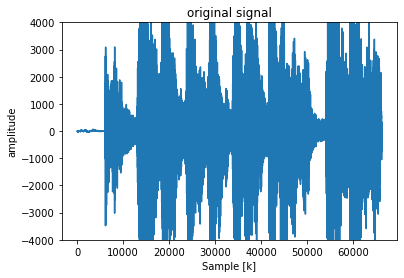

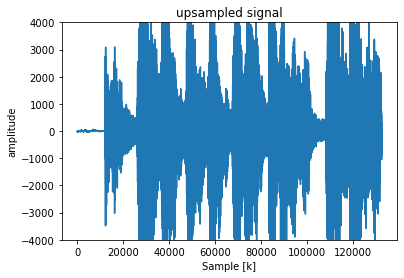

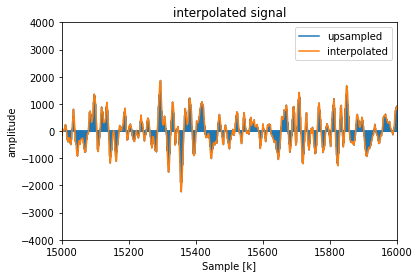

In [69]:
from scipy.interpolate import interp1d
def upsample(fs_in, fs_IR, data_in, data_IR):
    upsamp, up_data = match_fs(fs_in, fs_IR, data_in, data_IR);
    k = np.arange(len(up_data))
    plt.figure()
    plt.plot(k,up_data)
#     plt.xlim([6000, 10000])
    plt.ylim([-4000, 4000])
    plt.xlabel('Sample [k]')
    plt.ylabel('amplitude')
    plt.title('original signal')
    
    #inserting zeros in between original sample
    n = up_data.shape
    size = n[0]
    out = np.zeros(upsamp*size, dtype = int)
    out[::upsamp] = up_data
    k_up = np.arange(len(out))
    plt.figure()
    plt.plot(k_up,out)
#     plt.xlim([12000, 20000])
    plt.ylim([-4000, 4000])
    plt.xlabel('Sample [k]')
    plt.ylabel('amplitude')
    plt.title('upsampled signal')
    
    #upsampling & interpolation
    data_interp = np.interp(k_up, k_up[out!=0], out[out!=0])
    print(f"New Upsamp&Interp Data = {data_interp}, upsamp factor = {upsamp}" )
    plt.figure()
    plt.plot(k_up,out)
    plt.plot(k_up, data_interp)
    plt.xlim([15000, 16000])
    plt.ylim([-4000, 4000])
    plt.xlabel('Sample [k]')
    plt.ylabel('amplitude')
    plt.title('interpolated signal')
    plt.legend(['upsampled', "interpolated"])
    # plt.plot(k_up, ynew)
    return data_interp
upsample(fs_in, fs_IR, data_in, data_IR)

In [ ]:
#convolving normalized version of input signal with 
"""need to manage different sampling rates"""
conv_sig = signal.convolve(normalized_IR, normalized_din, mode='full', method='auto')
print(conv_sig)


In [ ]:
#converting convolved signal from float64 back to int16
new_conv_sig = utility.float2pcm(conv_sig, 'int16')
print(new_conv_sig)
print(f"Old Conv Sig type = {conv_sig.dtype}")
print(f"New Conv Sig type = {new_conv_sig.dtype}")

plt.plot(new_conv_sig, label = "reverbed");
plt.plot(data_in, label = "original");
plt.legend();
plt.xlabel("Samples");
plt.ylabel("Amplitude");

In [ ]:
play_obj = sa.play_buffer(new_conv_sig, 1, 2, fs_in)

In [ ]:
play_obj.stop()

In [ ]:
play_obj1 = sa.play_buffer(data_in, 1, 2, fs_in)

In [ ]:
play_obj.stop()

In [ ]:
# ----- STEREO ---------

In [ ]:
#that audio file is mono, so we're gonna make it stereo by copying it
new_data_in = np.stack((data_in, data_in), axis=-1)

In [ ]:
#new stereo data
print(f".Wav Contents = {new_data_in}")
print(f".Wav Shape = {new_data_in.shape}")
length = new_data_in.shape[0] / fs_in
print(f".Wav Length = {length}s")
print(f"Sampling Rate= {fs_in} Hz")

print(f"bit depth= {type(new_data_in[0][0])}")

#playing stereo
play_obj = sa.play_buffer(new_data_in, 2, 2, fs_in)


In [ ]:
#downsampling, removing every odd
a = [1.0, 0, 1.0]
b = [a[i] for i in range(len(a)) if i %2 == 0]
b


[4.  4.5 5.  5.5 6.  6.  6.  6.5 7.  7.5 8.  8.5 9.  9. ]


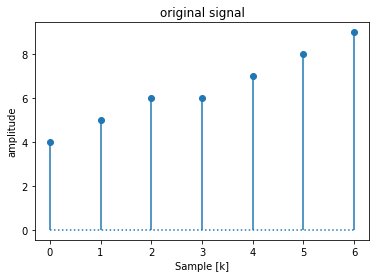

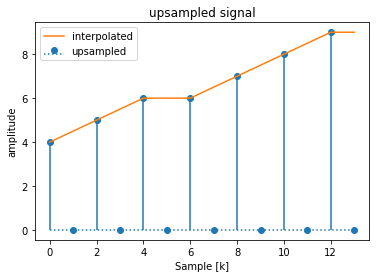

In [22]:
#upsampling
#mono
from scipy.interpolate import interp1d

#creating example original signal
x= np.array([4,5,6,6,7,8,9])
k = np.arange(len(x))
plt.figure()
plt.stem(k,x,basefmt = ":")
plt.xlabel('Sample [k]')
plt.ylabel('amplitude')
plt.title('original signal')
#inserting zeros in between original sample
upsamp = 2
n = x.shape
size = n[0]
out = np.zeros(upsamp*size, dtype = int)
out[::upsamp] = x
k_up = np.arange(len(out))
plt.figure()
plt.stem(k_up,out, basefmt = ":")
plt.xlabel('Sample [k]')
plt.ylabel('amplitude')
plt.title('upsampled signal')

#upsampling & interpolation
x_interp = np.interp(k_up, k_up[out!=0], out[out!=0])
print(x_interp)
plt.plot(k_up, x_interp)
plt.legend(["interpolated", 'upsampled'])
# plt.plot(k_up, ynew)


In [ ]:
from scipy.interpolate import interp1d
x = np.arange(6)
y = out[::2]
print(x,y)
# f2 = interp1d(x, y, kind = 'cubic')
plt.plot(x, f2(x))

In [ ]:

#stereo
upsamp = 2
x = np.array([[1,2,3],[4,5,6]])
m,n = x.shape
out = np.zeros((m,upsamp*n),dtype=x.dtype)
out[:,::upsamp] = x
out